#Deep Sentiment Analaysis
---

**Objective:** The goal from this exercise is to learn how to integrate Deep Learning into Natural Language Processing through Deep Sentiment Analysis.
The sections of this colab exercise are:
1. Keras Embedding Layer
2. Dataset loading
3. Data preparation
4. Feature extraction using Word Embeddings
5. Recurrent Neural Network model
6. Plotting training details

# Keras Embedding Layer

Before we start with the Sentiment Analysis exercise, let's look at an example of how to use a Keras Embedding layer.

In this example, we will build a `Sequential` model with an `Embedding` layer to learn the embeddings of a series of simple documents defined in the docs variable.


In [1]:
from numpy import array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding

# define documents
docs = ['Well done!',
		'Good work',
		'Great effort',
		'nice work',
		'Excellent!',
		'Weak',
		'Poor effort!',
		'not good',
		'poor work',
		'Could have done better.']

# define class labels
labels = array([1,1,1,1,1,0,0,0,0,0])

# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(docs)
vocab_size = len(t.word_index) + 1

# integer encode the documents
encoded_docs = t.texts_to_sequences(docs)
print(encoded_docs)

# pad documents to a max length of 4 words
max_length = 4
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs)

# define the model
model = Sequential()
model.add(Embedding(vocab_size, 8, input_length=max_length))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

# summarize the model
model.summary()

# fit the model
model.fit(padded_docs, labels, epochs=50, verbose=0)

# evaluate the model
loss, accuracy = model.evaluate(padded_docs, labels, verbose=0)
print('Accuracy: %f' % (accuracy*100))

[[6, 2], [3, 1], [7, 4], [8, 1], [9], [10], [5, 4], [11, 3], [5, 1], [12, 13, 2, 14]]
[[ 6  2  0  0]
 [ 3  1  0  0]
 [ 7  4  0  0]
 [ 8  1  0  0]
 [ 9  0  0  0]
 [10  0  0  0]
 [ 5  4  0  0]
 [11  3  0  0]
 [ 5  1  0  0]
 [12 13  2 14]]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4, 8)              120       
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 153 (612.00 Byte)
Trainable params: 153 (612.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Accuracy: 89.999998


# Sentiment Analysis

Text classification is one of the important tasks of text mining.

![alt text](http://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1535125878/NLTK3_zwbdgg.png)

In this notebook, we will perform Sentiment Analysis on IMDB movies reviews. Sentiment Analysis is the art of extracting people's opinion from digital text. We will use a regression model from Scikit-Learn able to predict the sentiment given a movie review.

We will use [the IMDB movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/), which consists of 50,000 movies review (50% are positive, 50% are negative).




---


This is the same exercise we saw in the previous lesson but the differences here are:


*   We are using **Word Embeddings** for feature extraction instead of Bag-of-Words. This is done by adding an `Embedding` layer as the first layer in the Sequential model.
*   We are using a deep **Recurrent Neural Network** for modeling.

These changes should allow the model to better understand the dataset and give better results.

## Data Preparation

### 1. Import Modules

In [2]:
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from tensorflow import keras

# download Punkt Sentence Tokenizer
nltk.download('punkt')
# download stopwords
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### 2. Download and Load Dataset

In [3]:
# download IMDB dataset
!wget "https://raw.githubusercontent.com/javaidnabi31/Word-Embeddding-Sentiment-Classification/master/movie_data.csv" -O "movie_data.csv"

# list files in current directory
!ls -lah

--2024-03-18 17:32:13--  https://raw.githubusercontent.com/javaidnabi31/Word-Embeddding-Sentiment-Classification/master/movie_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65862309 (63M) [text/plain]
Saving to: ‘movie_data.csv’

movie_data.csv      100%[===================>]  62.81M   327MB/s    in 0.2s    

2024-03-18 17:32:14 (327 MB/s) - ‘movie_data.csv’ saved [65862309/65862309]

total 63M
drwxr-xr-x 1 root root 4.0K Mar 18 17:32 .
drwxr-xr-x 1 root root 4.0K Mar 18 17:27 ..
drwxr-xr-x 4 root root 4.0K Mar 15 13:25 .config
-rw-r--r-- 1 root root  63M Mar 18 17:32 movie_data.csv
drwxr-xr-x 1 root root 4.0K Mar 15 13:25 sample_data


In [4]:
# the path to the IMDB dataset
dataset_path = 'movie_data.csv'

# read file (dataset) into our program using pandas
data = pd.read_csv(dataset_path)

# display first 5 rows
data.head()

,review,sentiment
0,I went and saw this movie last night after bei...,1
1,Actor turned director Bill Paxton follows up h...,1
2,As a recreational golfer with some knowledge o...,1
3,"I saw this film in a sneak preview, and it is ...",1
4,Bill Paxton has taken the true story of the 19...,1


### 3. Clean Text

Define the `clean_review` function to apply on the dataset reviews.

In [5]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

english_stopwords = stopwords.words('english')
stemmer = PorterStemmer()

def clean_review(text):
  # convert to lower case
  text = text.lower()

  # remove none alphabetic characters
  text = re.sub(r'[^a-z]', ' ', text)

  # stem words
  # split into words
  tokens = word_tokenize(text)

  # stemming of words
  stemmed = [stemmer.stem(word) for word in tokens]

  text = ' '.join(stemmed)

  # remove stopwords
  text = ' '.join([word for word in text.split() if word not in english_stopwords])

  return text


# apply to all dataset
data['clean_review'] = data['review'].apply(clean_review)
data.head()

,review,sentiment,clean_review
0,I went and saw this movie last night after bei...,1,went saw thi movi last night coax friend mine ...
1,Actor turned director Bill Paxton follows up h...,1,actor turn director bill paxton follow hi prom...
2,As a recreational golfer with some knowledge o...,1,recreat golfer knowledg sport histori wa pleas...
3,"I saw this film in a sneak preview, and it is ...",1,saw thi film sneak preview delight cinematogra...
4,Bill Paxton has taken the true story of the 19...,1,bill paxton ha taken true stori us golf open m...


### 4. Split Dataset

In [6]:
from sklearn.model_selection import train_test_split

X = data['clean_review'].values
y = data['sentiment'].values

# Split data into 50% training & 50% test
# let's all use a random state of 42 for example to ensure having the same split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(25000,) (25000,)
(25000,) (25000,)


### 5. Feature Extraction with Word Embeddings

Instead of going with Bag-of-Words for feature extraction, we are using Keras'  `Tokenizer()` class to prepare the data for the `Embedding` layer.


**Question 1:** Do the necessary steps to extract features with word embeddings

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# define your tokenizer (with num_words=10000)
tokenizer_obj = Tokenizer(num_words=10000)

# assign an index (number) to each word using fit_on_texts function
tokenizer_obj.fit_on_texts(x_train)

# will be used later to pad sequences
max_length = 120

# define vocabulary size
vocab_size = len(tokenizer_obj.word_index) + 1

# transform each text to a sequence of integers (to be used later in embeddings layer)
x_train_tokens = tokenizer_obj.texts_to_sequences(x_train)
x_test_tokens = tokenizer_obj.texts_to_sequences(x_test)

# apply post-padding to the sequences
x_train_pad = pad_sequences(x_train_tokens, maxlen=max_length, padding='post')
x_test_pad = pad_sequences(x_test_tokens, maxlen=max_length, padding='post')

In [10]:
x_train[0], x_train_pad[0]

('would reccomend thi film everyon onli fan rocker luciano ligabu film buff becaus sincer move funni true becaus ligabu born storytel film lover everi frame hi film made love care becaus hi charact love ask love becaus italian debut film lousi thi one done outsid real joy watch listen becaus stefano accorsi gorgeou remind andrea pazienza wa like freccia beauti talent good lost hi life becaus heroin ligabu show unglamor ugli without indulg easi moral becaus film speak heart ear soul becaus live experi fm radio wa exactli like thank luciano',
 array([  20,    2,    5,  239,   22,  130, 6148,    5, 2142,   34, 2075,
         203,   84,  224,   34, 1295, 2188,    5,  803,  101, 1136,    6,
           5,   42,   33,  241,   34,    6,   13,   33,  396,   33,   34,
         902, 1685,    5, 2060,    2,    7,  152,  886,   81, 1490,   16,
         923,   34, 1426,  627, 3992,    4,    8,  137,  320,   12,  391,
           6,   60,   34, 1453,   26, 1292,  139, 2273,  721,  837,   34,
         

## Recurrent Neural Network

Now it's time to build the deep RNN network that will model the data. The network has to start with an `Embedding` layer, then we add one or multiple Recurrent layers and finally finish with a couple of Dense layers.

### Building and Training the RNN model

**Question 2:** Build a proper RNN

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

embedding_dim = 300

# FILL BLANKS
# build the neural network
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

# compile model: assign loss & optimizer
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 300)          15439500  
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 15659277 (59.74 MB)
Trainable params: 15659277 (59.74 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
# train model
model.fit(x_train_pad, y_train, batch_size=32, epochs=5, validation_data=(x_test_pad, y_test))

Epoch 1/5
782/782 [==============================] - 60s 74ms/step - loss: 0.6523 - accuracy: 0.6028 - val_loss: 0.6686 - val_accuracy: 0.5588
Epoch 2/5
782/782 [==============================] - 20s 25ms/step - loss: 0.4546 - accuracy: 0.7731 - val_loss: 0.3317 - val_accuracy: 0.8658
Epoch 3/5
782/782 [==============================] - 16s 20ms/step - loss: 0.2403 - accuracy: 0.9072 - val_loss: 0.3100 - val_accuracy: 0.8745
Epoch 4/5
782/782 [==============================] - 13s 17ms/step - loss: 0.1579 - accuracy: 0.9442 - val_loss: 0.3529 - val_accuracy: 0.8726
Epoch 5/5
782/782 [==============================] - 13s 16ms/step - loss: 0.0951 - accuracy: 0.9707 - val_loss: 0.3978 - val_accuracy: 0.8681


### Plot training details

We visualize the training parameters to have a better understanding of the model's convergence.

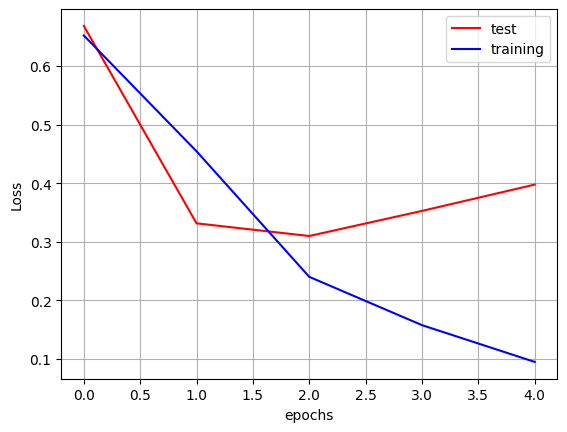

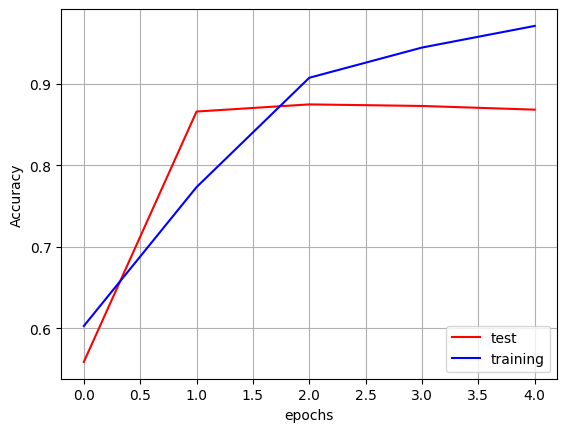

In [15]:
def plot_accuracy_and_loss(model):
    epochs = model.history.params['epochs']
    epochs = range(epochs)
    val_loss = model.history.history['val_loss']
    val_accuracy = model.history.history['val_accuracy']
    training_loss = model.history.history['loss']
    training_accuracy = model.history.history['accuracy']

    plt.plot(epochs, val_loss, 'r', label='test')
    plt.plot(epochs, training_loss, 'b', label='training')
    plt.xlabel('epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

    plt.plot(epochs, val_accuracy, 'r', label='test')
    plt.plot(epochs, training_accuracy, 'b', label='training')
    plt.xlabel('epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

plot_accuracy_and_loss(model)